In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 80

In [3]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [3]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\sange\.labelmerc


In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
tf.executing_eagerly()

True

In [8]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [9]:
images.as_numpy_iterator().next()

b'data\\images\\dbdbb5b0-9fe9-11ee-8622-fed86ba91a1b.jpg'

In [10]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [11]:
images = images.map(load_image)

In [12]:
images.as_numpy_iterator().next()

array([[[139,  79,  43],
        [139,  79,  42],
        [138,  79,  39],
        ...,
        [136,  61,   6],
        [135,  60,   5],
        [135,  60,   3]],

       [[140,  80,  44],
        [139,  79,  43],
        [138,  79,  39],
        ...,
        [135,  59,   7],
        [134,  59,   4],
        [134,  59,   2]],

       [[139,  79,  45],
        [139,  79,  43],
        [140,  78,  41],
        ...,
        [136,  60,  10],
        [134,  61,   8],
        [134,  61,   6]],

       ...,

       [[199, 236, 254],
        [198, 235, 253],
        [198, 235, 253],
        ...,
        [ 28,  15,   6],
        [ 30,  16,   5],
        [ 32,  18,   7]],

       [[198, 237, 254],
        [198, 237, 254],
        [198, 237, 254],
        ...,
        [ 25,  12,   3],
        [ 27,  13,   2],
        [ 29,  12,   2]],

       [[197, 236, 253],
        [198, 237, 254],
        [199, 238, 255],
        ...,
        [ 24,  11,   2],
        [ 27,  10,   0],
        [ 26,   9,   0]]

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [14]:
image_generator = images.batch(4).as_numpy_iterator()

In [15]:
plot_images = image_generator.next()

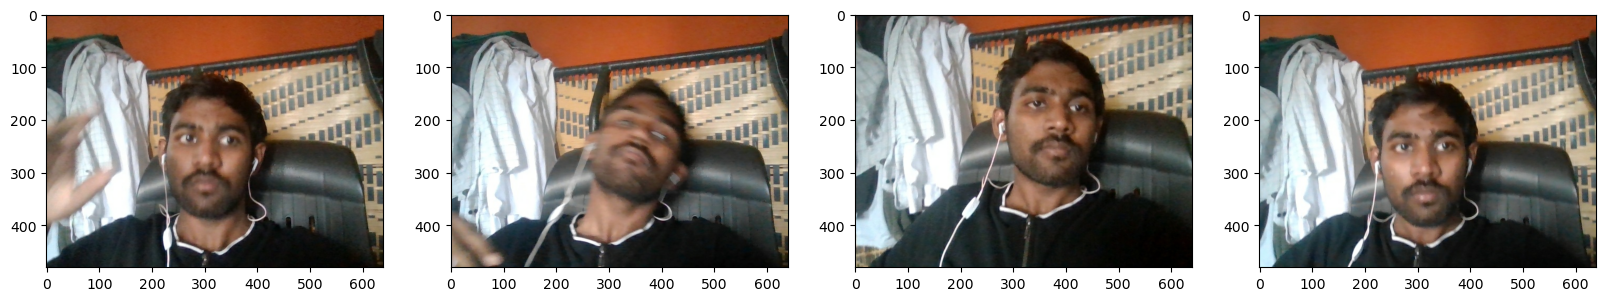

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [18]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

In [19]:
import albumentations as alb

In [20]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [23]:
img = cv2.imread(os.path.join('data','train', 'images','d9538fee-9fe9-11ee-acfd-fed86ba91a1b.jpg'))

In [24]:
with open(os.path.join('data', 'train', 'labels', 'd9538fee-9fe9-11ee-acfd-fed86ba91a1b.json'), 'r') as f:
    label = json.load(f)

In [25]:
label['shapes'][0]['points']

[[249.94652406417117, 241.87165775401067],
 [441.3903743315508, 475.0267379679144]]

In [26]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [27]:
coords

[249.94652406417117, 241.87165775401067, 441.3903743315508, 475.0267379679144]

In [28]:
coords = list(np.divide(coords, [640,480,640,480]))

In [29]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [30]:
augmented['bboxes'][0][2:]

(0.47345216874628626, 0.4802852049910875)

In [31]:
augmented['bboxes']

[(0.04802139037433162, 0.0, 0.47345216874628626, 0.4802852049910875)]

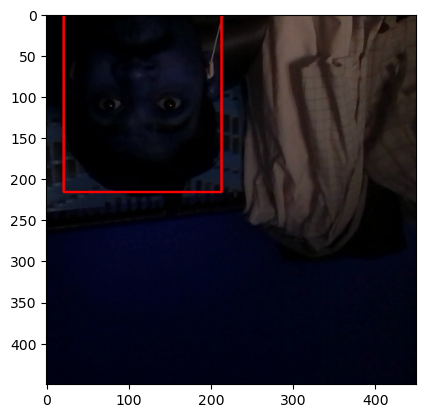

In [32]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [34]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type
image must be numpy array type
